## Programming Exercise 7: K-means Clustering and Principal Component Analysis
#### Author - Rishabh Jain

In [1]:
import warnings,os
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

from PIL import Image,ImageFilter
from scipy.io import loadmat

### 1&nbsp;&nbsp;&nbsp;&nbsp;K-means Clustering

#### Problem Statement
In this part of the exercise, we will implement the K-means algorithm and use it for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

#### 1.1&nbsp;&nbsp;&nbsp;&nbsp;Implementing K-means
The K-means algorithm is a method to autmatically cluster similar data together. We have a training set $\{x^{(1)}...x^{(m)}\}$ where $x^{(i)}\epsilon R^{n}$. The intution behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines the guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on assignments.
```
# Initialize Centroids
centroids=kMeansInitCentroids(X,K)
for i in range(iter):
    # Cluster assignment step: Assign each data point to the closest centroid. idx(i) corrsponds to c(i),
    # the index of the centroid assigned to example i
    idx=findClosestCentroids(X,centroids)
    
    # Move centroid step: Compute means based on centroid assignments
    centroids=computeMeans(X,idx,K);
```

The inner loop of the algoritm carries two steps:
1. Assigning each training example $x^{(i)}$ to its closest centroid.
2. Recomputing the mean of each centroid using the points assigned to it.
The K-means algorithm will always converge to some final set of means for the centroids.

##### 1.1.1&nbsp;&nbsp;&nbsp;&nbsp;Find closest centroids
In the "Cluster assignment" phase of the K-means algorithm, **the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current position of centroid.**
$$c^{(i)}:=j\text{ that minimizes }||x^{(i)}-\mu||^{2}$$

where $c^{(i)}$ is the index of the centroid that is closes to $x^{(i)}$, $\mu^{(j)}$ is the position of $j^{th}$ centroid.

In [2]:
def findClosestCentroids(X,centroids):
    '''Computes and returns the closest centroid label for the given samples'''
    m,n=X.shape
    # Number of clusters(K)
    K=centroids.shape[0]
    c=np.zeros(m)
    for i in range(m):
        x=X[i,:]
        norm=np.zeros(K)
        for k in range(K):
            norm[k]=np.dot((x-centroids[k,:]),(x-centroids[k,:]).T)
        c[i]=np.argmin(norm)
    return c

##### 1.1.2&nbsp;&nbsp;&nbsp;&nbsp;Computing centroid means
Here, we will calculate the centroid new location based on the examples assigned to that centroid. The cordinates of that centroid is mean of the cordinates of all the samples assigned to it.
$$\mu^{(j)}=\frac{\sum_{i\epsilon c_k}x^{(i)}}{|C_k|}$$

where $C_k$ is the set of examples assigned to that centroid.

In [3]:
def computeCentroids(X,c,K):
    '''Computes and returns the new centroids by computing the means of samples assigned to that centroid'''
    m,n=X.shape
    centroids=np.zeros(shape=(K,n))
    for k in range(K):
        x=X[c==k,:]
        centroids[k,:]=x.mean(axis=0)
    return centroids

#### 1.2&nbsp;&nbsp;&nbsp;&nbsp;K-means on example dataset

#### 1.3&nbsp;&nbsp;&nbsp;&nbsp;Random Initialization
A good strategy for initializing the centroids is to select a random sample from the training set. Example used above first select the random K centroids, finds and compute the closest centroid for each sample in training set.

In [4]:
def runKMeans(X,K,maxIters,plotProgress=False):
    m,n=X.shape
    # Randomly selecting K centroids from X
    indices=np.random.randint(0,m,K)
    centroids=X[indices,:]
    history={}
    for i in range(1,maxIters+1):
        print(f'ITERATION : {i}',end='\r')
        c=findClosestCentroids(X,centroids)
        history[i]=centroids
        centroids=computeCentroids(X,c,K)
    if plotProgress==True and X.shape[1]==2:
        fig,ax=plt.subplots(figsize=(10,8))
        # Plotting points belonging to same cluster
        for k in range(K):
            x=X[c==k,:]
            sns.scatterplot(x[:,0],x[:,1],ax=ax,legend=False)
        # Plotting centroids history
        for i in range(1,maxIters):
            for k in range(K):
                temp=np.array([history[i][k,:],history[i+1][k,:]])
                sns.lineplot(temp[:,0],temp[:,1],color='black')
                sns.scatterplot(temp[:,0],temp[:,1],color='black',marker='x',s=50)
                if i+1==maxIters:
                    sns.scatterplot([temp[1,0]],[temp[1,1]],color='red',marker='x',s=100)
    return c,centroids

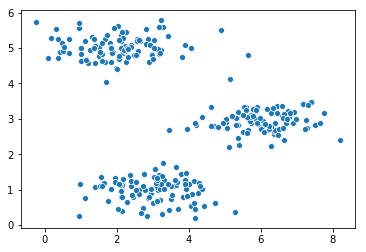

In [5]:
mat=loadmat('ex7data2.mat')
X=mat['X']
sns.scatterplot(X[:,0],X[:,1]);

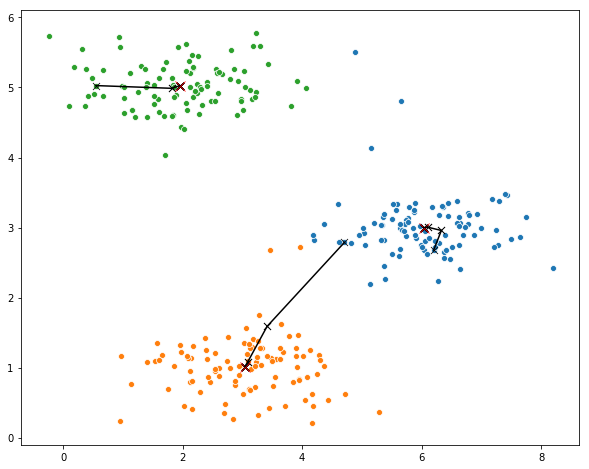

In [6]:
K=3
maxIter=10

labels,centroids=runKMeans(X,K,maxIter,plotProgress=True)

**Note : Red Cross markers are the final centroids of that cluster.**

#### 1.4&nbsp;&nbsp;&nbsp;&nbsp;Image compression with K-means

In this example, we will apply K-means for image compression. In a straightforward 24-bit color representation of an image, each pixel is represented as 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often referred to as RGB encoding. **Our image contains thousands of colors, and we will reduce the number of colors to 16 colors.**

Concretely, we will treat every pixel in the original image as a part of our dataset and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in 3-dimensional space (RGB).

##### 1.4.1&nbsp;&nbsp;&nbsp;&nbsp;K-means on pixels

On loading the image, we get a 3-D matrix whose first two indices identify a pixel position and whose last index represent a red,green and blue value. Here will reshape the 3-D matrix into mX3 matrix of pixel colors and call our K-means function on it.

**EXAMPLE 1:**

In [7]:
K=16
maxIter=5

img=Image.open('bird.png')
mat=np.asarray(img)
print(f'IMAGE DIMENSION : {mat.shape}')
X=mat.reshape((-1,3))
print(f'X SHAPE : {X.shape}')

labels,centroids=runKMeans(X,K,maxIter)
print(f'\n\nTOP {K} COLORS :\n\n',centroids)

IMAGE DIMENSION : (128, 128, 3)
X SHAPE : (16384, 3)
ITERATION : 5

TOP 16 COLORS :

 [[237.64668404 214.72690414 170.81523313]
 [168.49756098 138.24878049  81.00487805]
 [ 28.77245385  29.98610247  27.53536611]
 [163.35454545 115.48181818  53.21590909]
 [ 95.10465116 111.81007752 157.65116279]
 [158.7862069  107.4        101.11724138]
 [134.01360544 115.01360544  75.31972789]
 [214.36433196 155.80694526  78.43201883]
 [ 76.5295587   68.99333888  68.37885096]
 [113.13917526  99.32989691  69.39175258]
 [129.40458015 111.60687023 103.55725191]
 [118.84246575  88.39041096  84.60273973]
 [141.34123223 129.5971564  123.63033175]
 [126.68053245  89.57237937  40.07986689]
 [161.03243243 176.51351351 197.46306306]
 [187.52291105 161.48450135 123.87398922]]


After finding the top $K=16$ colors to represent the image, we will now assign each pixel position to its closest centroids. This allows us to represent the original image using centroid assignment of each pixel. We have significantly reduced the number of bits that are required to describe the image. The original image required 24 bits for each of 128 x 128 pixels, resulting in total of 128 x 128 x 4 = 363,216 bits. The new representation requires some overhead storage in form of a dictionary of 16 colors, each of which require 24 bits, but the image itself then only requires 4 bits per pixel location. The final number of bits used is therefore 16 x 24 + 128 x 128 X 4 = 65,920 bits, which corresponds to compressing the original image by about a factor of 6.

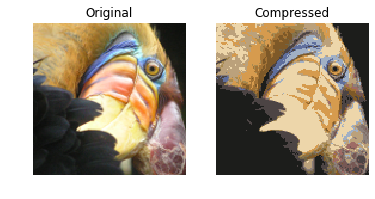

In [8]:
xCompressed=centroids[labels.astype(int),:]
xCompressed=np.uint8(xCompressed.reshape(mat.shape))
fig,ax=plt.subplots(1,2)
ax[0].imshow(img)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(Image.fromarray(xCompressed))
ax[1].set_title('Compressed')
ax[1].axis('off');

**EXAMPLE 2:**

In [9]:
K=6
maxIter=10

img=Image.open('parrot.png')
mat=np.asarray(img)
print(f'IMAGE DIMENSION : {mat.shape}')
X=mat.reshape((-1,3))
print(f'X SHAPE : {X.shape}')

labels,centroids=runKMeans(X,K,maxIter)
print(f'\n\nTOP {K} COLORS :\n\n',centroids)

IMAGE DIMENSION : (200, 200, 3)
X SHAPE : (40000, 3)
ITERATION : 10

TOP 6 COLORS :

 [[ 23.25658915  44.28507752  40.54534884]
 [236.19668803 208.30769231  28.27361111]
 [232.23546726  70.47093451   5.34142752]
 [126.74717322 128.69877883   8.45714609]
 [162.94011072  34.44640161   5.8389532 ]
 [ 11.87511525 138.27793144 150.14977789]]


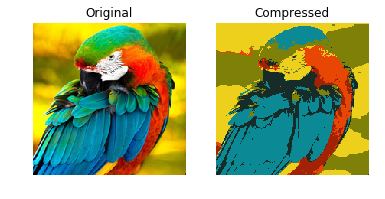

In [10]:
xCompressed=centroids[labels.astype(int),:]
xCompressed=np.uint8(xCompressed.reshape(mat.shape))
fig,ax=plt.subplots(1,2)
ax[0].imshow(img)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(Image.fromarray(xCompressed))
ax[1].set_title('Compressed')
ax[1].axis('off');

### 2&nbsp;&nbsp;&nbsp;&nbsp;Principal Component Analysis